In [51]:
from warnings import filterwarnings
filterwarnings('ignore')

In [52]:
import pandas as pd

train_data = pd.read_csv('/content/Titanic_train.csv')
test_data = pd.read_csv('/content/Titanic_test.csv')


In [53]:
print(train_data.isnull().sum())


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


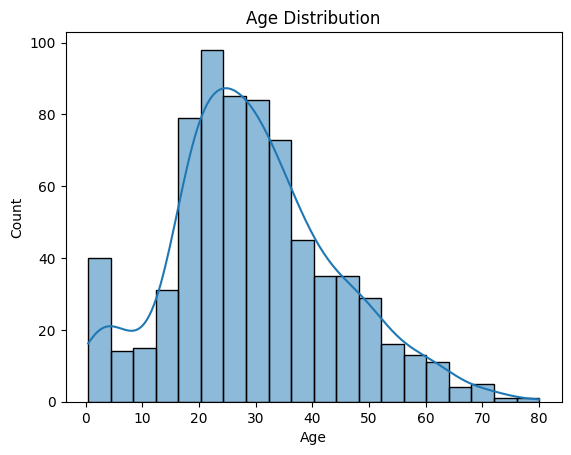

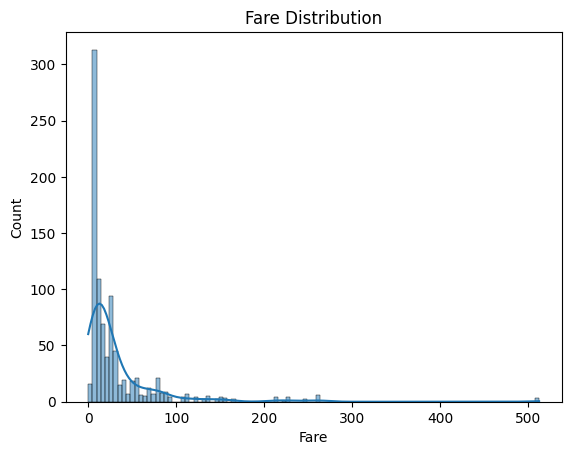

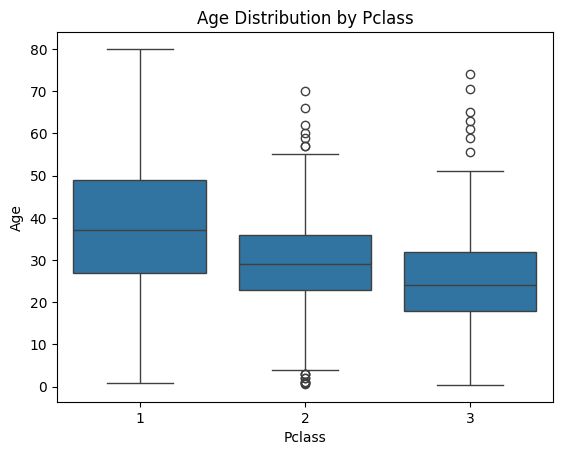

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Age Distribution
sns.histplot(train_data['Age'].dropna(), kde=True)
plt.title('Age Distribution')
plt.show()

# Fare Distribution
sns.histplot(train_data['Fare'].dropna(), kde=True)
plt.title('Fare Distribution')
plt.show()

# Box Plots
sns.boxplot(x='Pclass', y='Age', data=train_data)
plt.title('Age Distribution by Pclass')
plt.show()


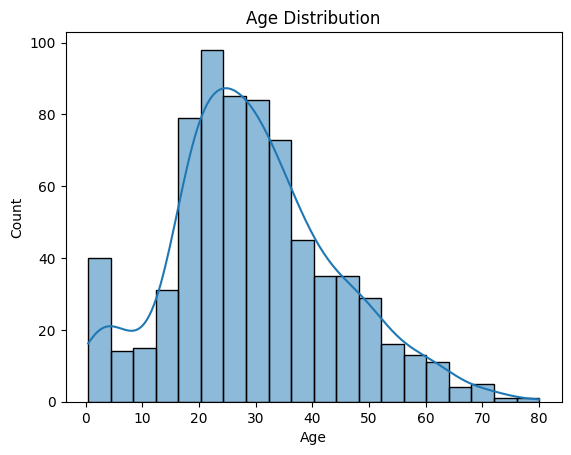

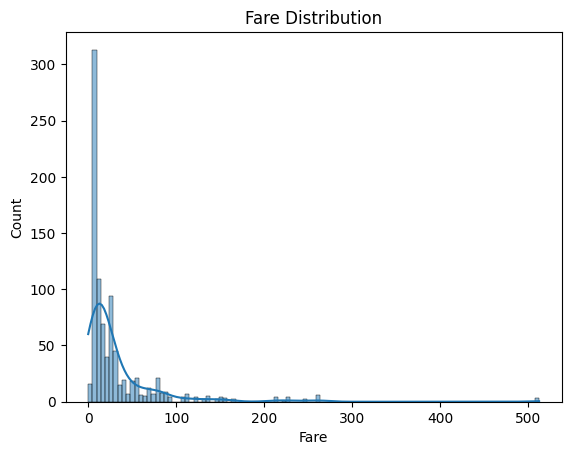

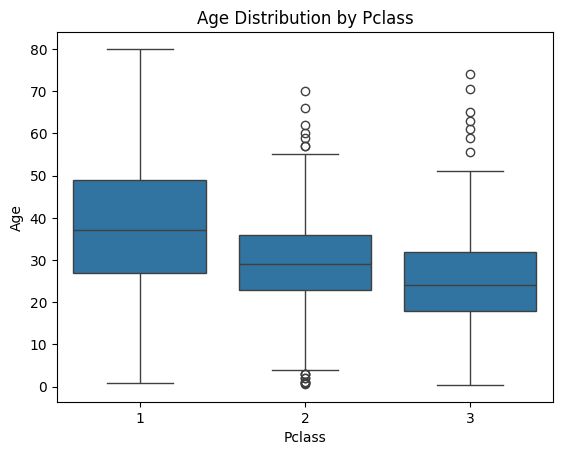

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Age Distribution
sns.histplot(train_data['Age'].dropna(), kde=True)
plt.title('Age Distribution')
plt.show()

# Fare Distribution
sns.histplot(train_data['Fare'].dropna(), kde=True)
plt.title('Fare Distribution')
plt.show()

# Box Plots
sns.boxplot(x='Pclass', y='Age', data=train_data)
plt.title('Age Distribution by Pclass')
plt.show()


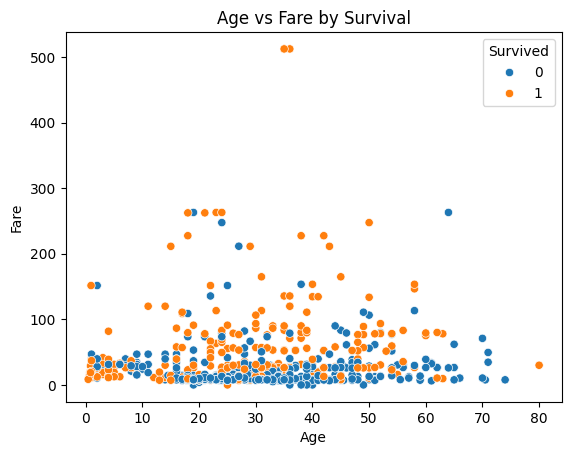

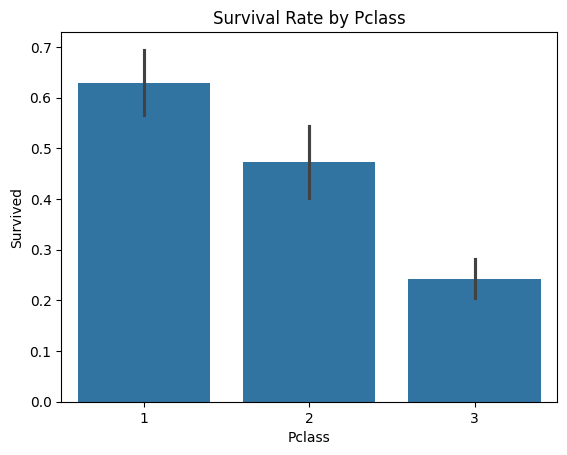

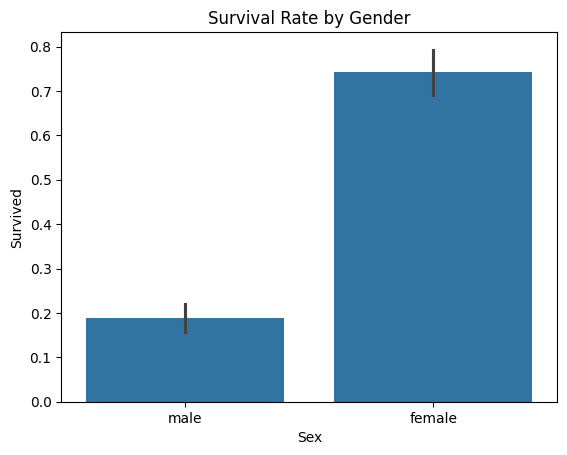

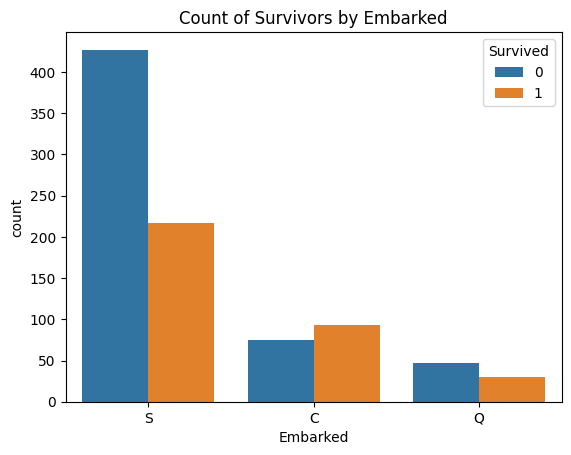

In [56]:
# Scatter Plot: Age vs Fare by Survival
sns.scatterplot(x='Age', y='Fare', hue='Survived', data=train_data)
plt.title('Age vs Fare by Survival')
plt.show()

# Bar Plot: Survival Rate by Pclass
sns.barplot(x='Pclass', y='Survived', data=train_data)
plt.title('Survival Rate by Pclass')
plt.show()

# Bar Plot: Survival Rate by Gender
sns.barplot(x='Sex', y='Survived', data=train_data)
plt.title('Survival Rate by Gender')
plt.show()

# Count Plot: Count of Survivors by Embarked
sns.countplot(x='Embarked', hue='Survived', data=train_data)
plt.title('Count of Survivors by Embarked')
plt.show()



#Data Preprocessing:


In [57]:
#Impute Missing Values:
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
train_data['Fare'].fillna(train_data['Fare'].median(), inplace=True)


In [58]:
#Encode Categorical Variables:
train_data = pd.get_dummies(train_data, columns=['Sex', 'Embarked'], drop_first=True)


In [59]:
#Additional Preprocessing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data[['Age', 'Fare']] = scaler.fit_transform(train_data[['Age', 'Fare']])
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1


#Building Predictive Models:


In [60]:
from sklearn.model_selection import train_test_split

X = train_data.drop(['Survived'], axis=1)
y = train_data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Choose Evaluation Metrics:

Accuracy, precision, recall, F1-score

In [61]:
#Build and Train LightGBM Model:

import lightgbm as lgb

# Drop the problematic columns 'Name', 'Ticket', and 'Cabin'
X_train = X_train.drop(['Name', 'Ticket', 'Cabin'], axis=1)
X_test = X_test.drop(['Name', 'Ticket', 'Cabin'], axis=1)

train_data_lgb = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.002
params['boosting_type'] = 'gbdt' # dart
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10

lgb_model = lgb.train(params_lgb, train_data_lgb, num_boost_round=100)
y_pred_lgb = (lgb_model.predict(X_test) > 0.5).astype(int)

from sklearn.metrics import accuracy_score, classification_report
print("LightGBM Model Accuracy:", accuracy_score(y_test, y_pred_lgb))
print("LightGBM Model Report:\n", classification_report(y_test, y_pred_lgb))

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 444
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [62]:
#Build and Train XGBoost Model:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective='binary:logistic', learning_rate=0.05, max_depth=6, n_estimators=100)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Model Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Model Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Model Accuracy: 0.8212290502793296
XGBoost Model Report:
               precision    recall  f1-score   support

           0       0.81      0.90      0.86       105
           1       0.84      0.70      0.76        74

    accuracy                           0.82       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



In [63]:
#Cross-Validation and Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'num_leaves': [31, 50, 70]
}

grid_search_lgb = GridSearchCV(estimator=lgb.LGBMClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_lgb.fit(X_train, y_train)

grid_search_xgb = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_xgb.fit(X_train, y_train)

print("Best Parameters (LightGBM):", grid_search_lgb.best_params_)
print("Best Parameters (XGBoost):", grid_search_xgb.best_params_)


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

#Comparative Analysis
##1. Performance Metrics Comparison:

###Based on the model reports:

#LightGBM Model:

* Accuracy: 0.83

##Precision:

* Class 0: 0.85

* Class 1: 0.79

##Recall:

* Class 0: 0.86

* Class 1: 0.78

##F1-Score:

* Class 0: 0.85

* Class 1: 0.79

#XGBoost Model:

* Accuracy: 0.82

## Precision:

* Class 0: 0.81

* Class 1: 0.84

## Recall:

* Class 0: 0.90

* Class 1: 0.70

##F1-Score:

* Class 0: 0.86

* Class 1: 0.76

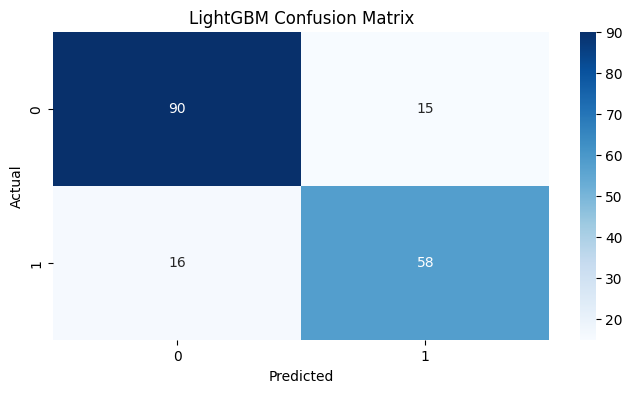

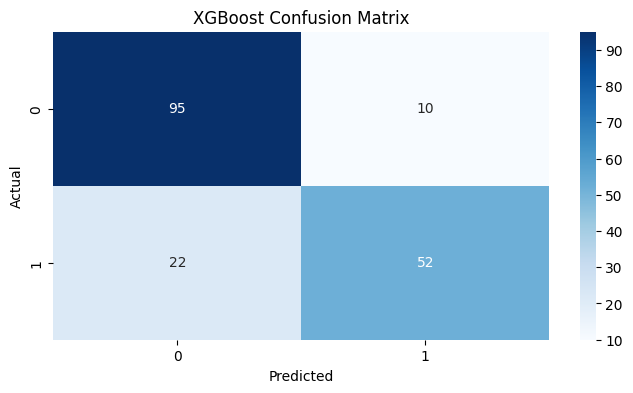

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# LightGBM Confusion Matrix
cm_lgb = confusion_matrix(y_test, y_pred_lgb)
plt.figure(figsize=(8, 4))
sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Blues')
plt.title('LightGBM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# XGBoost Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


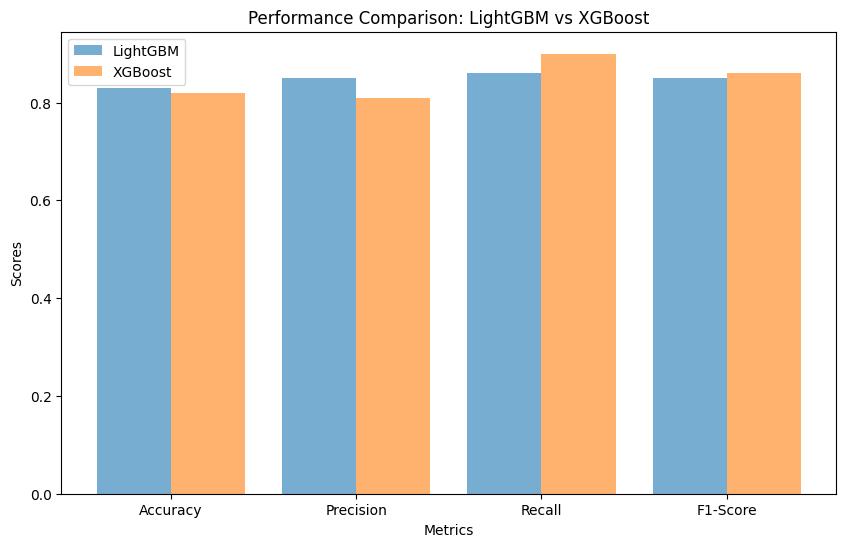

In [65]:
import matplotlib.pyplot as plt

# Metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
lightgbm_scores = [0.83, 0.85, 0.86, 0.85]
xgboost_scores = [0.82, 0.81, 0.90, 0.86]

x = range(len(metrics))

plt.figure(figsize=(10, 6))
plt.bar(x, lightgbm_scores, width=0.4, label='LightGBM', align='center', alpha=0.6)
plt.bar([p + 0.4 for p in x], xgboost_scores, width=0.4, label='XGBoost', align='center', alpha=0.6)

plt.xticks([p + 0.2 for p in x], metrics)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Performance Comparison: LightGBM vs XGBoost')
plt.legend()
plt.show()
